In [54]:
#this notebook uses the entire dataset (that is not included in this release, see repo README)
#we provide it to show how the results/figures/tables of the paper are generated

%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
name = "ds806" #change it to your name
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt 
%matplotlib inline
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
import seaborn as sns
sns.set_context("poster")
import glob
from sklearn.decomposition import PCA
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)
from utils import *
import time
import os

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.externals import joblib

import keras
from keras.layers import Input, Dense, Dropout
from keras.models import Model, model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Concat individual sensor features CSVs 

In [5]:
#frame = pd.read_csv("data/extracted_features_all_users_with_MVPA.csv", index_col=0)#no MVPA-noncal here
frame = pd.read_csv("data/extracted_features_all_users_with_MVPA_noncal.csv", index_col=0)
frame.shape

(12158, 116)

In [6]:
frame.head()

,25%_ACC,25%_ENMO,25%_MET_LPA,25%_MET_MVPA,25%_MET_VigPA,25%_MET_sed,25%_MVPA_noncal,25%_Sed_noncal,25%_VPA_noncal,25%_hrv_milliseconds,25%_mean_hr,50%_ACC,50%_ENMO,50%_MET_LPA,50%_MET_MVPA,50%_MET_VigPA,50%_MET_sed,50%_MVPA_noncal,50%_Sed_noncal,50%_VPA_noncal,50%_hrv_milliseconds,50%_mean_hr,75%_ACC,75%_ENMO,75%_MET_LPA,75%_MET_MVPA,75%_MET_VigPA,75%_MET_sed,75%_MVPA_noncal,75%_Sed_noncal,75%_VPA_noncal,75%_hrv_milliseconds,75%_mean_hr,RHR,age,bmi,count_ACC,count_ENMO,count_MET_LPA,count_MET_MVPA,count_MET_VigPA,count_MET_sed,count_MVPA_noncal,count_Sed_noncal,count_VPA_noncal,count_hrv_milliseconds,count_mean_hr,height,id,max_ACC,max_ENMO,max_MET_LPA,max_MET_MVPA,max_MET_VigPA,max_MET_sed,max_MVPA_noncal,max_Sed_noncal,max_VPA_noncal,max_hrv_milliseconds,max_mean_hr,mean_ACC,mean_ENMO,mean_MET_LPA,mean_MET_MVPA,mean_MET_VigPA,mean_MET_sed,mean_MVPA_noncal,mean_Sed_noncal,mean_VPA_noncal,mean_hrv_milliseconds,mean_mean_hr,min_ACC,min_ENMO,min_MET_LPA,min_MET_MVPA,min_MET_VigPA,min_MET_sed,min_MVPA_noncal,min_Sed_noncal,min_VPA_noncal,min_hrv_milliseconds,min_mean_hr,month,month_cos_time,month_sin_time,mvpa_daily_count,mvpa_daily_count_noncal,real_time,sed_daily_count,sed_daily_count_noncal,sex,slope_ACC,slope_ENMO,slope_MET_LPA,slope_MET_MVPA,slope_MET_VigPA,slope_MET_sed,slope_MVPA_noncal,slope_Sed_noncal,slope_VPA_noncal,slope_hrv_milliseconds,slope_mean_hr,std_ACC,std_ENMO,std_MET_LPA,std_MET_MVPA,std_MET_VigPA,std_MET_sed,std_MVPA_noncal,std_Sed_noncal,std_VPA_noncal,std_hrv_milliseconds,std_mean_hr,vpa_daily_count,vpa_daily_count_noncal,weight
0,0.0,0.057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,66.375999,0.015,2.543696,0.0,0.0,0.0,0.0,0.0,0.009,0.0,157.0,77.554001,0.234,38.849461,0.000000,0.000000,0.0,0.000000,0.0,0.216,0.0,211.0,89.494501,62.666730,46.0,28.563646,8258.0,8258.0,8258.0,8258.0,8258.0,8258.0,8258.0,8258.0,8258.0,8258.0,8258.0,1.839,608551N,3.297,546.632812,5.958082,5.958082,5.958082,0.499869,3.297,0.975,0.000,1555.0,136.427002,0.157728,26.205971,0.503840,0.307573,0.000721,0.026814,0.030209,0.127520,0.000000,175.058519,78.724571,0.0,0.057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-180.0,52.365002,3.0,6.123234e-17,1.000000,168.833333,26.166667,2011-03-17 12:38:00,1179.714286,1179.714286,1.0,-0.000008,-0.001269,-0.000055,-0.000047,-2.005316e-07,1.034424e-07,-0.000004,-3.796540e-06,0.000000e+00,0.005148,-0.001517,0.289485,47.991135,0.940380,0.836552,0.065565,0.068968,0.231807,0.194346,0.000000,93.889429,14.898837,1.000000,0.000000,96.6
1,0.0,0.057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,125.0,72.498001,0.000,0.057000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,203.0,79.259003,0.036,6.025071,0.000000,0.000000,0.0,0.018802,0.0,0.033,0.0,563.0,86.390999,68.391240,47.0,23.403175,9421.0,9421.0,9421.0,9421.0,9421.0,9421.0,9421.0,9421.0,9421.0,9421.0,9421.0,1.743,705051H,2.997,496.898895,4.474391,4.474391,0.000000,0.497736,2.997,0.975,0.000,1821.0,127.177002,0.063776,10.629453,0.146806,0.066505,0.000000,0.044098,0.019868,0.043908,0.000000,371.541575,79.729309,0.0,0.057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1547.0,58.625999,1.0,8.660254e-01,0.500000,32.125000,18.000000,2010-01-23 18:45:00,1177.625000,1177.625000,0.0,-0.000003,-0.000547,0.000010,-0.000002,0.000000e+00,-1.020129e-08,-0.000004,8.523049e-07,0.000000e+00,0.007257,0.000887,0.203587,33.752403,0.531500,0.403107,0.000000,0.089634,0.177140,0.108699,0.000000,350.484761,10.069210,0.000000,0.000000,71.1
2,0.0,0.057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,57.288500,0.000,0.057000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,70.0,65.306499,0.144,23.929281,0.000000,0.000000,0.0,0.000000,0.0,0.048,0.0,109.0,72.082998,55.442856,49.0,27.513542,8678.0,8678.0,8678.0,8678.0,8678.0,8678.0,8678.0,8678.0,8678.0,8678.0,8678.0,1.740,612538F,7.608,1261.309326,8.154249,8.154249,8.154249,0.497530,7.608,0.984,7.608,1703.0,137.863998,0.276521,45.900051,0.603344,0.460276,0.022634,0.034609,0.201595,0.074926,0.006138,105.800578,65.706253,0.0,0.057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1281.0,45.201000,7.0,-8.660254e-01,-0.500000,184.571429,109.428571,2013-07-25 12:40:00

### Introduce the VO2max label

#### Fenland I

In [7]:
fitness_df = pd.read_csv("/home/"+name+"/rds/rds-rjh234-deeplearning/FENLAND2/Releases_CRF_project/PHFENLANDR90002152019_26Nov2019/PHFENLANDR90002152019B_Prerelease_08Apr2020.csv")
fitness_df.head()

,serno,BetaBlocker_PA,OnBetablockers,OnBetablockers_P2,P_TR_FITNESS_est,P_TR_FITNESS_HighPt_est,P_TR_FITNESS_est_P2,P_TR_FITNESS_HighPt_est_P2,PAEE,HOME_PAEE,WORK_PAEE,LEIS_PAEE,COMMUTE_PAEE,SEDtime,LIGHTtime,MODERATEtime,VIGOROUStime,G_SMOKE,G_SMOKE_P2
0,500002T,0.0,0,NaN,41.306446,44.311794,NaN,NaN,14.79954,1.572039,11.29425,1.144687,0.788563,10.625000,0.000000,0.115476,0.000000,2.0,NaN
1,500006V,0.0,0,NaN,45.825691,50.242504,NaN,NaN,143.86010,2.602255,101.64820,38.537810,1.071767,4.715873,0.000000,1.671032,5.910714,0.0,NaN
2,500009P,0.0,0,False,32.716530,41.422867,31.935993,39.594959,21.02536,1.152320,11.29425,7.459547,1.119250,8.309524,0.017857,0.441369,0.071429,0.0,0.0
3,500011S,0.0,0,NaN,33.840206,39.073009,NaN,NaN,34.56553,6.646819,11.29425,9.841133,6.783333,11.960320,0.163690,0.710218,0.000000,0.0,NaN
4,500012Z,0.0,0,NaN,30.893469,33.915581,NaN,NaN,50.85464,3.823255,29.36505,11.815720,5.850625,3.357143,5.404762,1.621429,0.000000,0.0,NaN


In [8]:
#Fenland 1 
fitness_df = pd.read_csv("/home/"+name+"/rds/rds-rjh234-deeplearning/FENLAND2/Releases_CRF_project/PHFENLANDR90002152019_26Nov2019/PHFENLANDR90002152019B_Prerelease_08Apr2020.csv")
fitness_df.index = fitness_df['serno'] #move the user_id to index
del fitness_df['serno']
fitness_df = fitness_df[['P_TR_FITNESS_HighPt_est']] #standartize column names with FII
fitness_df.rename(columns={'P_TR_FITNESS_HighPt_est': 'TR_FITNESS_HighPt_est'}, inplace=True)
fitness_df.shape

(12435, 1)

In [9]:
#merge Fenland 1 with sensors and remove missing fitness entries
frame_with_fitness =  pd.merge(frame, fitness_df, left_on='id', right_on='serno').dropna(how='any') 
frame_with_fitness.shape

(11059, 117)

In [10]:
#remove timestamp, count_ features and index (somehow the feature extraction created an index column)
frame_with_fitness = frame_with_fitness.loc[:,~frame_with_fitness.columns.str.startswith('real_')]
frame_with_fitness = frame_with_fitness.loc[:,~frame_with_fitness.columns.str.startswith('count_')]
frame_with_fitness = frame_with_fitness.loc[:,~frame_with_fitness.columns.str.startswith('index')]

#remove treadmill informed MVPA variables
frame_with_fitness = frame_with_fitness.loc[:,~frame_with_fitness.columns.str.contains('_MET_')]
frame_with_fitness = frame_with_fitness.loc[:,~frame_with_fitness.columns.str.endswith('daily_count')]

#remove acceleration informed MVPA variables
#frame_with_fitness = frame_with_fitness.loc[:,~frame_with_fitness.columns.str.endswith('_noncal')]
frame_with_fitness.shape

(11059, 70)

#### Fenland II

In [12]:
#Fenland 2 repeats
fitness_df_2 = pd.read_stata("/home/"+name+"/rds/rds-rjh234-deeplearning/FENLAND2/Releases_CRF_project/Fen2_Summary_fitness_vars_Apr_2020/Fen2_summary_fitness_vars_IP_8Apr2020.dta")
fitness_df_2['id'] = fitness_df_2.id[:-2].astype(str).str[:-2]
fitness_df_2 = fitness_df_2[['id', 'TR_FITNESS_HighPt_est',]] 
fitness_df_2.shape

(3041, 2)

In [13]:
#we merge the repeats with FI and generate two ID groups so that we can select train/test sets later
repeats = pd.merge(fitness_df_2, frame_with_fitness, on='id', suffixes = ("_repeats","_f1")).dropna(how='any') 
IDs_repeats = frame_with_fitness[frame_with_fitness['id'].isin(repeats.id)].id
IDs_controls = frame_with_fitness[~frame_with_fitness['id'].isin(repeats.id)].id
IDs_repeats.to_csv("data/FII_repeats_cohort_IDs.csv") #save IDs (2K)
frame_with_fitness.id.to_csv("data/FI_cohort_IDs.csv") #save IDs (11K)
print (IDs_repeats.shape, IDs_controls.shape)

(2675,) (8384,)


### Split to disjoint train/test sets

In [15]:
X_train, y_train = frame_with_fitness[frame_with_fitness.index.isin(IDs_controls.index.values)].iloc[:,:-1],frame_with_fitness[frame_with_fitness.index.isin(IDs_controls.index.values)].iloc[:,-1]
X_test, y_test = frame_with_fitness[frame_with_fitness.index.isin(IDs_repeats.index.values)].iloc[:,:-1],frame_with_fitness[frame_with_fitness.index.isin(IDs_repeats.index.values)].iloc[:,-1]


mask = np.isin(X_test.id, X_train.id)
assert mask.all() == False

IDs = X_test.id #to be used in embedding user lookup later

#drop the userID (string hence keep only numeric data)
X_train = X_train._get_numeric_data()
X_test = X_test._get_numeric_data()

print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8384, 68) (2675, 68) (8384,) (2675,)


In [16]:
X_train.columns

Index(['25%_ACC', '25%_ENMO', '25%_MVPA_noncal', '25%_Sed_noncal',
       '25%_VPA_noncal', '25%_hrv_milliseconds', '25%_mean_hr', '50%_ACC',
       '50%_ENMO', '50%_MVPA_noncal', '50%_Sed_noncal', '50%_VPA_noncal',
       '50%_hrv_milliseconds', '50%_mean_hr', '75%_ACC', '75%_ENMO',
       '75%_MVPA_noncal', '75%_Sed_noncal', '75%_VPA_noncal',
       '75%_hrv_milliseconds', '75%_mean_hr', 'RHR', 'age', 'bmi', 'height',
       'max_ACC', 'max_ENMO', 'max_MVPA_noncal', 'max_Sed_noncal',
       'max_VPA_noncal', 'max_hrv_milliseconds', 'max_mean_hr', 'mean_ACC',
       'mean_ENMO', 'mean_MVPA_noncal', 'mean_Sed_noncal', 'mean_VPA_noncal',
       'mean_hrv_milliseconds', 'mean_mean_hr', 'min_ACC', 'min_ENMO',
       'min_MVPA_noncal', 'min_Sed_noncal', 'min_VPA_noncal',
       'min_hrv_milliseconds', 'min_mean_hr', 'month', 'month_cos_time',
       'month_sin_time', 'mvpa_daily_count_noncal', 'sed_daily_count_noncal',
       'sex', 'slope_ACC', 'slope_ENMO', 'slope_MVPA_noncal',
       's

In [17]:
#flag to train only with anthro/metadata
antrhopometrics = False

In [18]:
if antrhopometrics==True:
    X_train =  X_train[[ 'height', 'weight', 'sex', 'age', 'bmi','RHR']] #'RHR'
    X_test =  X_test[[ 'height', 'weight', 'sex', 'age', 'bmi','RHR']]
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)    

(8384, 68) (2675, 68) (8384,) (2675,)


## Non-model estimation (Tanaka equation)

47.52785046728972 76.74781308411217 174.73050467289744 62.47181445921501


<AxesSubplot:>

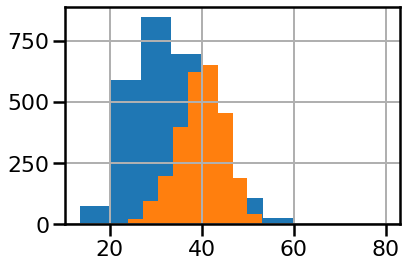

In [354]:
# VO2max = 15.0 (ml*minˆ-1) * Body Mass (kg) *  (HRmax / HRrest)
# [source Estimation of VO2max from the ratio between HRmax and HRrest--the Heart Rate Ratio Method, Niels et al]

# where HRmax can be 208-0.7*age 
# [source: Age-predicted maximal heart rate revisited, Tanaka et al]

X_test['HRmax'] = 208-0.7*X_test['age']
X_test['prediction'] = (15.0 * X_test['weight'] * (X_test['HRmax']/ X_test['RHR']))/100

print (X_test['age'].mean(),X_test['weight'].mean(), X_test['HRmax'].mean(), X_test['RHR'].mean())\

X_test['prediction'].hist()
y_test.hist()

### Normalize and denoise (PCA)

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
pca_flag = True
if pca_flag==True:
    pca_explained = 0.9999
    pca = PCA(pca_explained) 
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    print ("Explained variance:", pca.explained_variance_ratio_.cumsum()) 
    plt.plot(pca.explained_variance_ratio_.cumsum())

Explained variance: [0.19198117 0.31598844 0.40743699 0.48652977 0.55559902 0.61339824
 0.6527179  0.68484599 0.71507354 0.74295512 0.76729297 0.78747861
 0.80581373 0.82315224 0.83976298 0.85593665 0.87179033 0.88657134
 0.90045146 0.91382236 0.92611413 0.93540032 0.94358754 0.95082055
 0.95712849 0.96285126 0.96839968 0.97358831 0.97837773 0.98230121
 0.98575082 0.98878    0.99128152 0.99299078 0.9944609  0.99582106
 0.99700933 0.99768711 0.99830756 0.99888574 0.99924818 0.99946226
 0.99966094 0.99980443 0.999873   0.99993376]


In [21]:
#save both scaler and PCA mapping for transfer learning later
from sklearn.externals import joblib
pca_filename = "data/PCA_FI_mapping_09999.save"
joblib.dump(pca, pca_filename) 

scaler_filename = "data/scaler_FI.save"
joblib.dump(scaler, scaler_filename) 

['data/scaler_FI.save']

### Check that the two splits have similar VO2max ranges

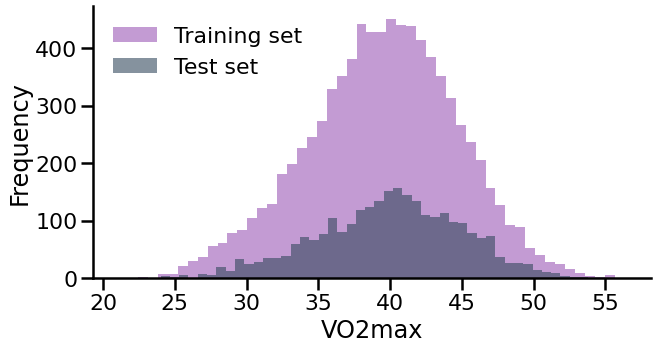

In [387]:
plt.figure(figsize=(10,5))
ax=y_train.hist(bins=50, alpha=0.6, label='Training set', color=flatui[0])
y_test.hist(bins=50, alpha=0.6, label='Test set',color=flatui[4])
plt.xlabel('VO2max'); plt.ylabel('Frequency')
plt.legend(frameon=False)
ax.grid(False);sns.despine()
plt.show()
plt.savefig('data/train_test_label_distribution.pdf', bbox_inches="tight") 

In [60]:
y_train.describe(), y_test.describe()

(count    8384.000000
 mean       39.453342
 std         5.223509
 min        21.063538
 25%        36.057396
 50%        39.678070
 75%        43.060010
 max        55.648129
 Name: TR_FITNESS_HighPt_est, dtype: float64,
 count    2675.000000
 mean       39.974317
 std         5.063181
 min        24.010044
 25%        36.615772
 50%        40.236561
 75%        43.525448
 max        56.413044
 Name: TR_FITNESS_HighPt_est, dtype: float64)

### Train model

In [110]:
training_mode = 'NN'

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 46)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               6016      
_________________________________________________________________
batch_normalization_23 (Batc (None, 128)               512       
_________________________________________________________________
dropout_23 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_24 (Batc (None, 128)               512       
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
__________

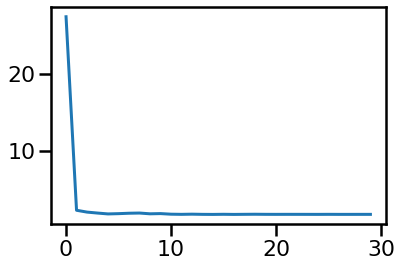

In [108]:
if training_mode=='linear_model':
    model = LinearRegression()
    clf = model.fit(X_train, y_train)
    print (clf)
    print ("saving model..")
    joblib.dump(clf, './models/linear_model_FI.pkl') 
    #print ("---------")
elif training_mode=='NN':
    input_layer = Input(shape=(X_train.shape[1],))    
    x = Dense(128, activation='elu',)(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='elu',)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    final = Dense(1)(x)

    clf = Model(input_layer, final)
    clf.summary()
    clf.compile(optimizer='adam', loss='mse')
    
    # Create a folder and store the model
    model_time = time.strftime("%Y%m%d-%H%M%S") #use timestamp as folder name...
    path = 'models/%s/'%model_time
    os.makedirs(os.path.dirname('./models/%s/'%model_time))
    # Save architecture for this model
    open('models/%s/model_architecture.json'%model_time, 'w').write(clf.to_json())

    #DON'T CHANGE THE FILEPATH NAMING CONVENTION, THE EVALUATION SCRIPT PARSING DEPENDS ON IT
    filepath="models/%s/weights-regression-improvement-{val_loss:.2f}.hdf5"%model_time
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
       factor=0.1,
       patience=5,
       verbose=1)

    checkpointer = ModelCheckpoint(monitor='val_loss', filepath=filepath, verbose=1, save_best_only=True, mode='min')
    early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='auto')

    history = clf.fit(X_train, y_train.values, callbacks=[early_stop,reduce_lr,checkpointer], #change to y_train for supervised mode, or X_train for AE
                    epochs=500,
                    batch_size=32,
                    shuffle=True,
                    validation_split=0.1)
    plt.plot(history.history['val_loss'])


### Evaluation

In [101]:
if training_mode=='NN':
    #del clf
    folder =  '20201109-013142' #model_time #'20201109-013142' #use current model with model_time or saved model e.g. '20200115-105719'
    #load best model from the folder
    clf = model_from_json(open('./models/'+ folder +'/model_architecture.json').read())
    files = glob.glob('./models/'+folder+'/*.hdf5')
    #WARNING! DEPENDS ON THE NAMING CONVENTION!
    #we parse the filename ('./models/20191029-125927/weights-regression-improvement-51.03.hdf5')
    #and we convert the MSE to a float in order to sort, the first is the lowest (lowest val_loss)
    weights = sorted(files, key=lambda name: float(name[56:-5]))[0]
    print ("=============Best model loaded:", weights)
    clf.load_weights(weights)   
    clf.compile(loss="mse", optimizer="adam")
    clf.summary()
    #predicted = model.predict([X_test_timeseries_normalized,X_test_demographics_normalized_temporal,X_test_demographics_normalized_resting]) #X_test_demographics_normalized_resting, X_test_demographics_normalized_temporal])  #X_test_demographics_normalized (first if multimodal)
elif training_mode== 'linear_model':
    linear_model = "models/linear_model_FI.pkl"
    clf = joblib.load(linear_model)    

=============Best model loaded: ./models/20201109-013142/weights-regression-improvement-8.89.hdf5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 46)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 128)               6016      
_________________________________________________________________
batch_normalization_36 (Batc (None, 128)               512       
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_37 (Batc (None, 128)               512       
____________________________________________

In [102]:
def evaluate (X,y, ml_mode=True):
    if ml_mode:
        predicted = np.squeeze(clf.predict(X))
        print (clf)
    else:
        predicted = X
    mse, rmse, mae, std_mae, r2, mape, corr =  error_metrics(y.astype('float').values,predicted)
    return predicted

#### Held-out test set

In [103]:
predicted_test = evaluate(X_test, y_test)

### Confidence Intervals

In [28]:
def CI95(predicted, y_test):
    print ("Data size:", len(y_test))
    #theory: https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading24.pdf
    from sklearn.utils import resample
    bootstrap=[]
    for i in tqdm(range(500)): 
        pairs = np.array(resample(predicted, y_test.astype('float'), replace=True)) #resample in pairs of (pred,y)
        pred , y = pairs[0,:], pairs[1,:] #select the data
        mse, rmse, mae, std_mae, r2, mape, corr =  error_metrics(y,pred)
        bootstrap.append([mse, rmse, mae, std_mae, r2, mape, corr]) #calculate the error and add to the list of boostrap iterations

    return bootstrap

In [29]:
bootstrap = CI95(predicted_test, y_test)

Data size: 2675


100%|██████████| 500/500 [00:01<00:00, 267.60it/s]


In [30]:
def CI95andMean (bootstrap, y_test, y_pred):
    print ("Data size:", len(y_test))
    #put CIs and mean values to the same dataframe (0.000 -> mean)
    final_metrics = pd.DataFrame(np.array(bootstrap))
    mean_values = pd.DataFrame(np.array(error_metrics(y_test.astype('float'),y_pred)))
    final_metrics.columns = ['mse', 'rmse', 'mae','std_mae', 'r2', 'mape', 'corr']
    display(pd.concat([final_metrics.quantile(0.025), final_metrics.quantile(0.975), 
               mean_values.set_index(final_metrics.quantile(0.025).index)],axis=1))

In [31]:
CI95andMean(bootstrap, y_test, predicted_test)

Data size: 2675


,0.025,0.975,0.000
mse,7.818171,9.082272,8.426964
rmse,2.796099,3.013681,2.902923
mae,2.181693,2.321919,2.253996
std_mae,1.737896,1.926416,1.829335
r2,0.648650,0.691845,0.671158
mape,0.056663,0.061145,0.058974
corr,0.807331,0.835191,0.821774


In [32]:
np.argsort((predicted_test - y_test.values) ** 2)[-10:] #last/best datapoints in terms of error

array([ 377, 2491, 2672, 2252, 1683, 1720, 1749,   95,  400, 1731])

In [33]:
print (predicted_test[2672], y_test.values[2672])

40.59452 30.101826000000003


## Projections + kNN

In [34]:
clf.layers

In [35]:
clf.input, clf.layers[-2].output #last dense layer

(<tf.Tensor 'input_10:0' shape=(?, 46) dtype=float32>,
 <tf.Tensor 'dropout_20/cond/Merge:0' shape=(?, 128) dtype=float32>)

In [36]:
layer_activations = K.function([clf.input, K.learning_phase()],
                               [clf.layers[-2].output])

In [37]:
len(X_test)

2675

In [38]:
activations_test=[]
for i in tqdm(range(0,len(X_test), 107)):  #107 (step) is a proper divisor of 2675
    #print (i)
    activations_test.append(layer_activations([X_test[i:i+107],]))


100%|██████████| 25/25 [00:00<00:00, 256.12it/s]


In [39]:
#[loops, steps, activation_dim] -> [loops*steps, activation_dim]
reshaped_arr_test = np.squeeze(np.array(activations_test)).reshape(len(X_test), np.array(activations_test).shape[3]) #the dim of the output layer
reshaped_arr_test.shape

(2675, 128)

In [40]:
from sklearn.neighbors import NearestNeighbors
def nearest_lookup(data):
    print (data.shape)
    nns = NearestNeighbors(n_neighbors=6).fit(data)
    distances, indices = nns.kneighbors(data)
    return distances, indices

In [41]:
distances_emb, indices_emb = nearest_lookup(reshaped_arr_test)
distances_orig, indices_orig = nearest_lookup(X_test)

(2675, 128)
(2675, 46)


In [42]:
#calculate squared error per sample and sort from lowest to highest (show errors and indices)
print(np.sort((predicted_test - y_test.values) ** 2), np.argsort((predicted_test - y_test.values) ** 2))

#use the first index (best datapoint-lowest error, Vo2max of pred/truth should be very close)
print (predicted_test[2343], y_test.values[2343])

[5.25749296e-08 1.36264640e-06 1.37135479e-06 ... 2.12602870e+02
 2.14859776e+02 2.59206393e+02] [2343 1465 2496 ...   95  400 1731]
42.08547 42.085239


In [43]:
np.argsort((predicted_test - y_test.values) ** 2)[:20] #top best datapoints in terms of error

array([2343, 1465, 2496, 1233, 2108,  606, 1054, 1243, 1532,  250, 1854,
       1806, 2387, 2540, 1404, 2247, 2429, 1181, 2620,  300])

In [44]:
query = 1181
print (distances_emb[query], distances_orig[query] )
print (indices_emb[query], indices_orig[query])

[0.        2.1074486 2.2565913 2.2572613 2.302287  2.32145  ] [0.         3.85551332 4.00698173 4.143403   4.20123826 4.23926803]
[1181  960 2520 2209  833  511] [1181  991  784 1710  498 2562]


In [45]:
print (IDs.values[indices_emb[query]], "\n", IDs.values[indices_orig[query]])

['507940P' '707986C' '609666J' '509164Y' '600704N' '705444P'] 
 ['507940P' '605973V' '501999F' '707320E' '605910S' '505535S']


In [50]:
queries = [1233, 1054, 1854, 2540, 2429, 1181]
query = 2540

In [51]:
#search those neighbor IDs in the original data
#we need the second line hack in order to sort the IDs in order of appearence (the query is first, closer knns later)

#pd.set_option('precision', 2) #enable only for this bit
query_results_emb = frame_with_fitness[frame_with_fitness.id.isin(IDs.values[indices_emb[query]])][['bmi','sex','age', 'TR_FITNESS_HighPt_est', 'id']]
query_results_emb = query_results_emb.reindex(query_results_emb.id.map({x: i for i, x in enumerate(IDs.values[indices_emb[query]])}).sort_values().index)
query_results_emb = query_results_emb.reset_index(drop=True)#
query_results_emb.rename({'TR_FITNESS_HighPt_est': 'VO2max', 'id': 'UserID'}, axis=1, inplace=True)

query_results_orig = frame_with_fitness[frame_with_fitness.id.isin(IDs.values[indices_orig[query]])][['bmi','sex','age',  'TR_FITNESS_HighPt_est', 'id']]
query_results_orig = query_results_orig.reindex(query_results_orig.id.map({x: i for i, x in enumerate(IDs.values[indices_orig[query]])}).sort_values().index)
query_results_orig = query_results_orig.reset_index(drop=True)
query_results_orig.rename({'TR_FITNESS_HighPt_est': 'VO2max', 'id': 'UserID'}, axis=1, inplace=True)

query_results_orig = query_results_orig.style.apply(lambda x: ['background: orange' 
                                  if (x.name in [0])
                                  else '' for i in x], axis=1).set_caption("Query (in orange) and original space neighbours")

query_results_emb = query_results_emb.style.apply(lambda x: ['background: orange' 
                                  if (x.name in [0])
                                  else '' for i in x], axis=1).set_caption("Query (in orange) and latent space neighbours")


display(query_results_orig, query_results_emb,)


,bmi,sex,age,VO2max,UserID
0,31.04,1.00,51.00,39.64,709081M
1,28.62,1.00,48.00,35.57,705958S
2,28.79,1.00,53.00,37.69,608070W
3,26.37,1.00,53.00,39.56,504475G
4,31.68,1.00,42.00,41.09,609159B
5,30.59,1.00,44.00,41.89,507394R


,bmi,sex,age,VO2max,UserID
0,31.04,1.00,51.00,39.64,709081M
1,28.62,1.00,48.00,35.57,705958S
2,28.79,1.00,53.00,37.69,608070W
3,29.77,1.00,43.00,37.90,503632W
4,29.02,1.00,58.00,40.35,707307P
5,23.48,1.00,59.00,32.14,707981V


In [656]:
from sklearn.manifold import TSNE
pca = TSNE(n_components=2,perplexity=35, init='pca') #TSNE
X_2D_model_embeddings = pca.fit_transform(reshaped_arr_test) 

In [657]:
pca_dense = TSNE(n_components=2,perplexity=35, init='pca') #TSNE
X_2D = pca_dense.fit_transform(X_test) 

In [658]:
import matplotlib
class MidpointNormalize(matplotlib.colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


In [2]:
from pylab import *
def plot_outcome(title, projection, outcome_legend, annot_index,distances, colormap_reversed='', annotate=False):
    
    #values taken from 03_repeats_CONTINUOUS_prediction_WEEK_LEVEL.ipynb
    #essentially these are min/max/median of y_test
    elev_min=24.010044 
    elev_max=56.41304399999999
    mid_val=40.236561 
    
    if annotate is False:
        alpha=0.4
    else:
        alpha=0.1
    plt.figure(figsize = (10,5))
    plt.scatter(projection[:, 0], projection[:, 1], 
                c=y_test,
                label="clinical", alpha=alpha, s=20, cmap='PRGn'+colormap_reversed,
                clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max),
               );
    
    if annotate is False:
        plt.xlabel('tSNE Dimension 1');plt.ylabel('tSNE Dimension 2')
        color_bar = colorbar()
        color_bar.set_label(outcome_legend, rotation=90)
        color_bar.set_alpha(1)
        color_bar.draw_all()
        color_bar.ax.get_yaxis().labelpad = 18
        
    
    if annotate is True:
        print (np.sum(distances))
        print (annot_index)
        plt.scatter(projection[annot_index[0], 0], projection[annot_index[0], 1], c='darkorange',zorder=1000, marker='+', s=150)
        for i in range(1, len(annot_index)):   
            print (i)
            plt.scatter(projection[annot_index[i], 0], projection[annot_index[i], 1], c='darkblue', marker='D', s=50)

    plt.xticks([], [])
    plt.yticks([], [])
    
    if annotate is False:
        plt.title(title)
        sns.despine(offset=1, trim=False)
        plt.savefig('data/tSNE_'+title+'_2022.pdf', bbox_inches="tight")
    else:
        sns.despine(offset=1, trim=False,bottom = True, left = True)
        plt.title('Total distance: '+str(np.round(np.sum(distances),2)))
        plt.savefig('data/tSNE_'+title+str(annot_index[0])+'_2022.pdf', bbox_inches="tight")
        


Bad key text.latex.unicode in file /home/ds806/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /home/ds806/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key nbagg.transparent in file /home/ds806/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 426 ('nbagg.transparent: True')
You probably need to get an updated matplotlibrc file from
https:

18.27306971332184
[1233 1316  717  858 2166 2225]
1
2
3
4
5
18.79034311126724
[1054 2566  621 1122 1929 1671]
1
2
3
4
5
22.034440411904004
[1854  529  639 1939    7 1313]
1
2
3
4
5
19.69708468791887
[2540 1503 1427 1867 2189  751]
1
2
3
4
5
24.673443745200156
[2429  102 2250 2187  481 1730]
1
2
3
4
5
20.446404344648226
[1181  991  784 1710  498 2562]
1
2
3
4
5


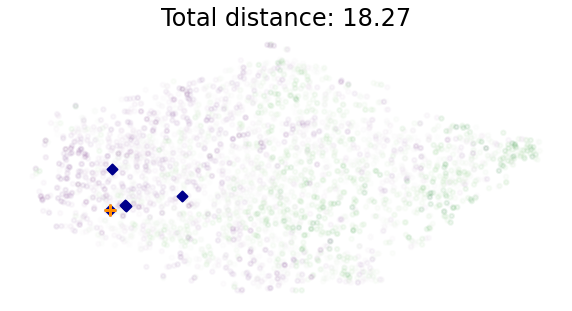

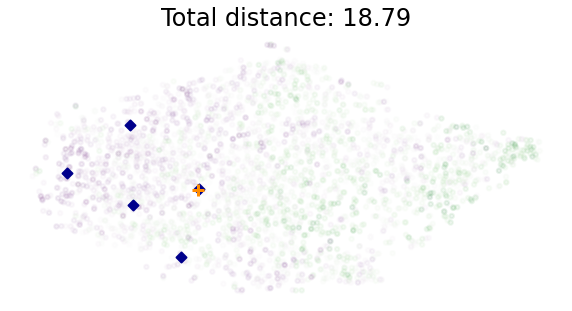

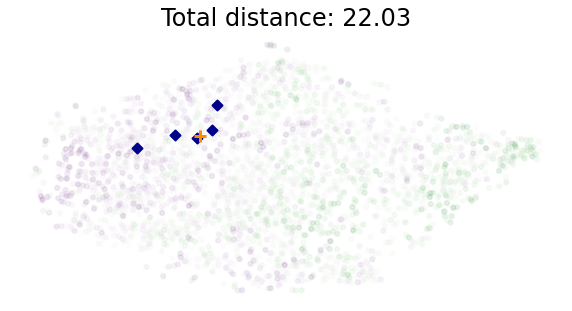

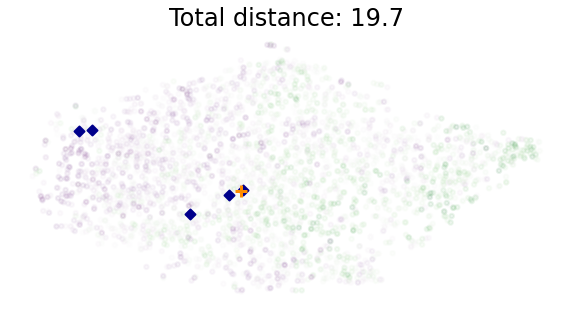

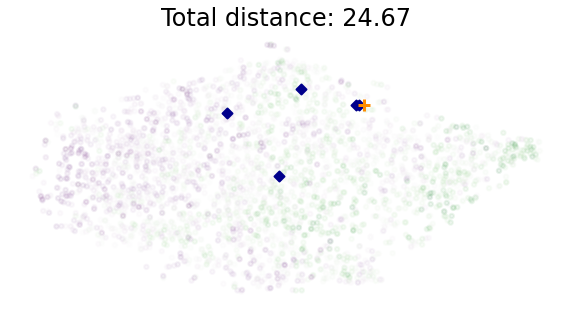

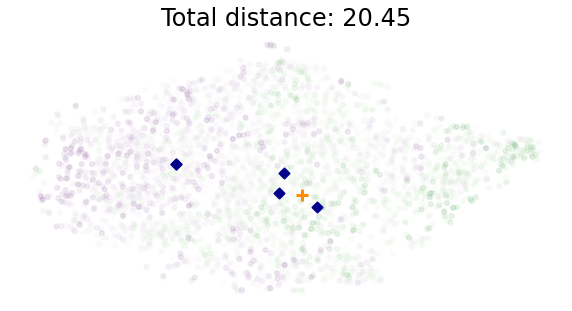

In [778]:
#2343, 1465, 2496, 1233, 2108

for i in neigh_list:
    plot_outcome('Original space', 
                 X_2D, 
                 '$VO2max_{current}$', indices_orig[i], distances_orig[i], annotate=True)

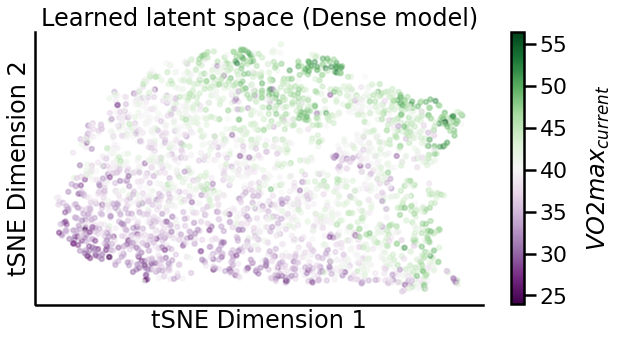

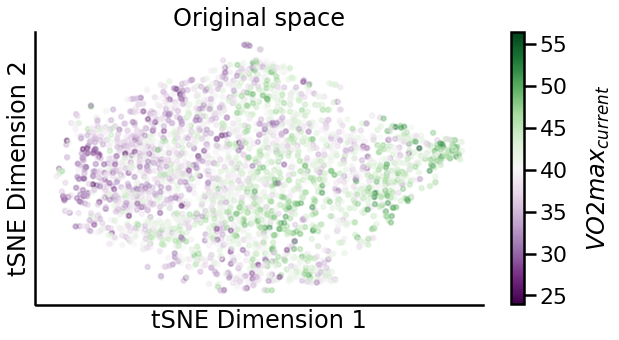

In [779]:
plot_outcome('Learned latent space (Dense model)', 
             X_2D_model_embeddings,
             '$VO2max_{current}$',indices_emb[query],distances_orig)

plot_outcome('Original space', 
             X_2D,
             '$VO2max_{current}$',indices_emb[query],distances_orig)

## Bland altman plot

Text(0.5, 1.0, 'Dense Model')

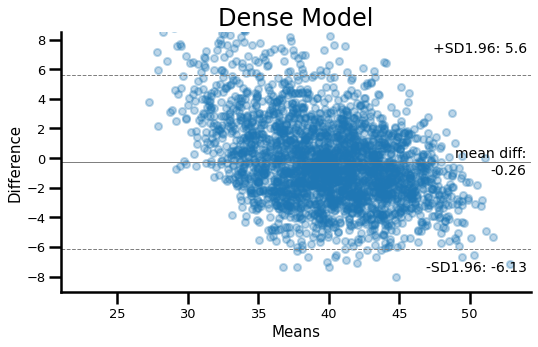

In [72]:
import statsmodels.api as sm
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(np.squeeze(clf.predict(X_test)),y_test.astype('float').values, ax = ax,
                          scatter_kwds={'alpha':0.3, 's': 50},)
ax.grid(False);sns.despine()
plt.title("Dense Model")
#plt.savefig('data/bland_alt_dense.pdf', bbox_inches="tight")     

### Stratify predictions based on demographics

In [57]:
pd.set_option('precision', 3)
metadata_dem = frame_with_fitness[frame_with_fitness.index.isin(IDs_repeats.index.values)].iloc[:,:-1][[ 'id', 'height', 'weight', 'sex', 'age', 'bmi',]]
metadata_dem['y_true'] = y_test.values
metadata_dem['y_pred'] = predicted_test
metadata_dem.head()

,id,height,weight,sex,age,bmi,y_true,y_pred
1,705051H,1.743,71.1,0.0,47.0,23.403,39.546,38.196
4,708547Y,1.845,74.0,1.0,47.0,21.739,49.077,45.909
7,709372B,1.510,73.0,0.0,51.0,32.016,39.987,35.423
11,601441F,1.800,95.5,1.0,38.0,29.475,45.210,44.304
12,703097M,1.672,54.3,0.0,42.0,19.423,39.598,40.568


In [85]:
bootstrap_sex1 = CI95(metadata_dem[metadata_dem.sex==1].y_pred,
                      metadata_dem[metadata_dem.sex==1].y_true,
                      )

CI95andMean(bootstrap_sex1, 
            metadata_dem[metadata_dem.sex==1].y_true,
            metadata_dem[metadata_dem.sex==1].y_pred)

Data size: 1303


100%|██████████| 500/500 [00:01<00:00, 471.03it/s]

Data size: 1303


,0.025,0.975,0.000
mse,7.133,8.917,7.987
rmse,2.671,2.986,2.826
mae,2.059,2.259,2.153
std_mae,1.687,1.975,1.831
r2,0.553,0.627,0.592
mape,0.050,0.056,0.053
corr,0.745,0.797,0.772


In [86]:
bootstrap_sex2 = CI95(metadata_dem[metadata_dem.sex==0].y_pred.values,
                      metadata_dem[metadata_dem.sex==0].y_true.values)

CI95andMean(bootstrap_sex2, 
            metadata_dem[metadata_dem.sex==0].y_true,
            metadata_dem[metadata_dem.sex==0].y_pred)

Data size: 1372


100%|██████████| 500/500 [00:00<00:00, 570.85it/s]

Data size: 1372


,0.025,0.975,0.000
mse,8.148,9.584,8.845
rmse,2.855,3.096,2.974
mae,2.259,2.444,2.350
std_mae,1.727,1.936,1.822
r2,0.567,0.629,0.599
mape,0.062,0.068,0.065
corr,0.756,0.799,0.779


In [87]:
print (metadata_dem.age.median()) #48
bootstrap_age1 = CI95(metadata_dem[metadata_dem.age<48.0001].y_pred,
                      metadata_dem[metadata_dem.age<48.0001].y_true.values)

CI95andMean(bootstrap_age1, 
            metadata_dem[metadata_dem.age<48.0001].y_true,
            metadata_dem[metadata_dem.age<48.0001].y_pred.values)

48.0
Data size: 1405


100%|██████████| 500/500 [00:01<00:00, 484.26it/s]

Data size: 1405


,0.025,0.975,0.000
mse,7.033,8.702,7.855
rmse,2.652,2.950,2.803
mae,2.064,2.259,2.161
std_mae,1.646,1.912,1.785
r2,0.650,0.708,0.680
mape,0.052,0.058,0.055
corr,0.809,0.847,0.829


In [88]:
bootstrap_age2 = CI95(metadata_dem[metadata_dem.age>48.0001].y_pred,
                      metadata_dem[metadata_dem.age>48.0001].y_true.values)

CI95andMean(bootstrap_age2, 
            metadata_dem[metadata_dem.age>48.0001].y_true,
            metadata_dem[metadata_dem.age>48.0001].y_pred.values)

Data size: 1270


100%|██████████| 500/500 [00:01<00:00, 484.36it/s]

Data size: 1270


,0.025,0.975,0.000
mse,8.190,9.879,9.059
rmse,2.862,3.143,3.010
mae,2.253,2.450,2.357
std_mae,1.744,1.983,1.871
r2,0.566,0.642,0.607
mape,0.061,0.066,0.064
corr,0.753,0.804,0.780


In [89]:
print (metadata_dem.weight.median()) #75.3
bootstrap_weight1 = CI95(metadata_dem[metadata_dem.weight<75.30001].y_pred,
                      metadata_dem[metadata_dem.weight<75.30001].y_true.values)

CI95andMean(bootstrap_weight1, 
            metadata_dem[metadata_dem.weight<75.30001].y_true,
            metadata_dem[metadata_dem.weight<75.30001].y_pred.values)

75.3
Data size: 1340


100%|██████████| 500/500 [00:01<00:00, 487.28it/s]

Data size: 1340


,0.025,0.975,0.000
mse,8.056,9.852,8.891
rmse,2.838,3.139,2.982
mae,2.222,2.418,2.322
std_mae,1.737,2.021,1.870
r2,0.604,0.669,0.639
mape,0.058,0.064,0.061
corr,0.781,0.824,0.803


In [90]:
bootstrap_weight1 = CI95(metadata_dem[metadata_dem.weight>75.30001].y_pred,
                      metadata_dem[metadata_dem.weight>75.30001].y_true.values)

CI95andMean(bootstrap_weight1, 
            metadata_dem[metadata_dem.weight>75.30001].y_true,
            metadata_dem[metadata_dem.weight>75.30001].y_pred.values)

Data size: 1335


100%|██████████| 500/500 [00:01<00:00, 471.93it/s]

Data size: 1335


,0.025,0.975,0.000
mse,7.205,8.692,7.961
rmse,2.684,2.948,2.822
mae,2.085,2.276,2.185
std_mae,1.668,1.900,1.785
r2,0.668,0.724,0.698
mape,0.054,0.060,0.057
corr,0.819,0.854,0.837


In [97]:
print (metadata_dem.bmi.median()) #25.5
bootstrap_bmi1 = CI95(metadata_dem[metadata_dem.bmi<25.56063001].y_pred,
                      metadata_dem[metadata_dem.bmi<25.56063001].y_true.values)

CI95andMean(bootstrap_bmi1, 
            metadata_dem[metadata_dem.bmi<25.56063001].y_true,
            metadata_dem[metadata_dem.bmi<25.56063001].y_pred.values)

25.56063
Data size: 1338


100%|██████████| 500/500 [00:01<00:00, 485.09it/s]

Data size: 1338


,0.025,0.975,0.000
mse,7.917,9.899,8.838
rmse,2.814,3.146,2.973
mae,2.208,2.414,2.303
std_mae,1.733,2.044,1.880
r2,0.604,0.670,0.640
mape,0.056,0.062,0.059
corr,0.779,0.825,0.804


In [98]:
bootstrap_bmi2 = CI95(metadata_dem[metadata_dem.bmi>25.56063001].y_pred,
                      metadata_dem[metadata_dem.bmi>25.56063001].y_true.values)

CI95andMean(bootstrap_bmi2, 
            metadata_dem[metadata_dem.bmi>25.56063001].y_true,
            metadata_dem[metadata_dem.bmi>25.56063001].y_pred.values)

Data size: 1337


100%|██████████| 500/500 [00:00<00:00, 523.36it/s]

Data size: 1337


,0.025,0.975,0.000
mse,7.323,8.748,8.016
rmse,2.706,2.958,2.831
mae,2.110,2.300,2.205
std_mae,1.674,1.879,1.775
r2,0.653,0.711,0.683
mape,0.056,0.062,0.059
corr,0.809,0.845,0.828


In [99]:
print (metadata_dem.height.median()) #1.706
bootstrap_height1 = CI95(metadata_dem[metadata_dem.height<1.706001].y_pred,
                      metadata_dem[metadata_dem.height<1.706001].y_true.values)

CI95andMean(bootstrap_height1, 
            metadata_dem[metadata_dem.height<1.706001].y_true,
            metadata_dem[metadata_dem.height<1.706001].y_pred.values)

1.706
Data size: 1343


100%|██████████| 500/500 [00:01<00:00, 441.10it/s]

Data size: 1343


,0.025,0.975,0.000
mse,8.014,9.563,8.771
rmse,2.831,3.092,2.962
mae,2.213,2.405,2.315
std_mae,1.743,1.968,1.847
r2,0.588,0.651,0.622
mape,0.061,0.066,0.064
corr,0.769,0.811,0.792


In [100]:
bootstrap_height2 = CI95(metadata_dem[metadata_dem.height>1.706001].y_pred,
                      metadata_dem[metadata_dem.height>1.706001].y_true.values)

CI95andMean(bootstrap_height2, 
            metadata_dem[metadata_dem.height>1.706001].y_true,
            metadata_dem[metadata_dem.height>1.706001].y_pred.values)

Data size: 1332


100%|██████████| 500/500 [00:01<00:00, 476.09it/s]

Data size: 1332


,0.025,0.975,0.000
mse,7.368,8.973,8.080
rmse,2.714,2.996,2.843
mae,2.107,2.298,2.193
std_mae,1.688,1.952,1.809
r2,0.582,0.651,0.619
mape,0.052,0.057,0.054
corr,0.767,0.812,0.790


## Compare to FII sensors and delta

In [107]:
#a dataframe with predictions and true values. useful for plotting
predicted_vs_truth = pd.DataFrame(np.column_stack((predicted_test,y_test, IDs_repeats )), columns=['predicted', 'truth', 'id'])


In [513]:
predicted_vs_truth.head()

,predicted,truth,id
0,37.8766,39.5463,705051H
1,47.171,49.0772,708547Y
2,35.8357,39.9868,709372B
3,44.658,45.2097,601441F
4,40.2854,39.5976,703097M


In [422]:
if training_mode== 'linear_model': #a linear model trained on FI used to predict FII sensors
    fII_predictions = pd.read_csv("data/linear_predictions_FenlandII_labels_userID_Apr2021.csv", index_col=0)
else:
    fII_predictions = pd.read_csv("data/predictions_FenlandII_labels_userID_Feb2021.csv", index_col=0)
fII_predictions.head()

,predicted,truth,id
0,36.287731,40.711899,705051H
1,44.951572,50.369160,708547Y
2,37.365791,41.704163,709372B
3,45.113762,41.931660,601441F
4,39.193707,38.957180,703097M


In [423]:
fII_predictions.shape

(2071, 3)

In [424]:
adaptability = pd.merge(predicted_vs_truth, fII_predictions, on='id', suffixes = ("_fI","_fII"))

In [425]:
display(adaptability.head(), adaptability.shape)

,predicted_fI,truth_fI,id,predicted_fII,truth_fII
0,38.1957,39.5463,705051H,36.287731,40.711899
1,45.9095,49.0772,708547Y,44.951572,50.369160
2,35.423,39.9868,709372B,37.365791,41.704163
3,44.3045,45.2097,601441F,45.113762,41.931660
4,40.5683,39.5976,703097M,39.193707,38.957180


(2042, 5)

In [426]:
adaptability["predicted_fI"] = adaptability["predicted_fI"].astype(float)
adaptability["truth_fI"] = adaptability["truth_fI"].astype(float)

In [427]:
adaptability["predicted_delta"] = adaptability.predicted_fI-adaptability.predicted_fII
adaptability["truth_delta"] = adaptability.truth_fI-adaptability.truth_fII

In [428]:
adaptability.head()

,predicted_fI,truth_fI,id,predicted_fII,truth_fII,predicted_delta,truth_delta
0,38.195683,39.546337,705051H,36.287731,40.711899,1.907951,-1.165562
1,45.909473,49.077190,708547Y,44.951572,50.369160,0.957901,-1.291970
2,35.423031,39.986778,709372B,37.365791,41.704163,-1.942760,-1.717385
3,44.304478,45.209652,601441F,45.113762,41.931660,-0.809284,3.277992
4,40.568310,39.597576,703097M,39.193707,38.957180,1.374603,0.640396


In [429]:
print (adaptability.truth_fI.mean(),adaptability.truth_fII.mean())

39.98476575073463 40.16853037543675


/home/ds806/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ds806/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ds806/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `h

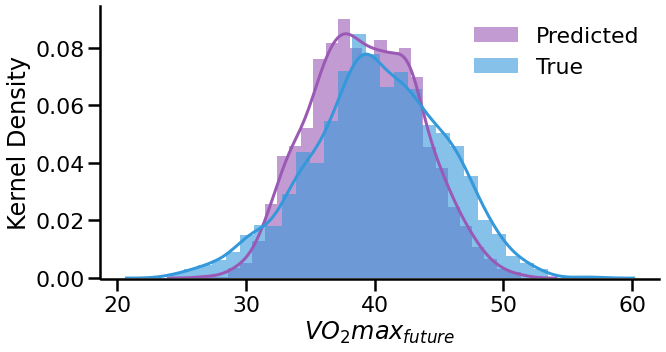

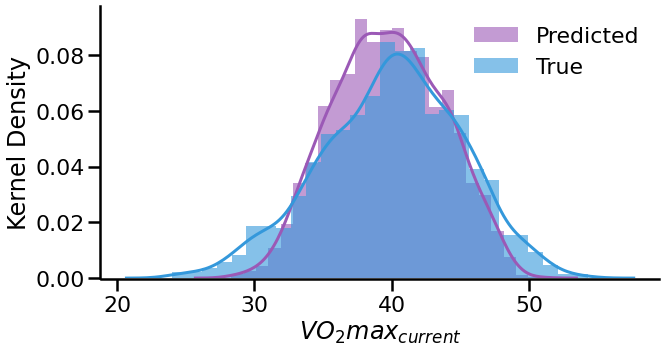

In [430]:

plt.figure(figsize=(10,5))
plt.ylabel('Kernel Density')
sns.despine(offset=1, trim=False)
sns.distplot(adaptability.predicted_fII,color=flatui[0],hist_kws=dict(alpha=0.6), label="Predicted")
sns.distplot(adaptability.truth_fII,color=flatui[1],hist_kws=dict(alpha=0.6),label="True")
plt.xlabel('$VO_{2}max_{future}$')
plt.legend(frameon=False, loc='best')
ax.grid(False);sns.despine()
#plt.savefig('data/FII_adaptability_distros.pdf', bbox_inches="tight")     
    
plt.figure(figsize=(10,5))
plt.ylabel('Kernel Density')
sns.despine(offset=1, trim=False)
sns.distplot(adaptability.predicted_fI,color=flatui[0],hist_kws=dict(alpha=0.6), label="Predicted")
sns.distplot(adaptability.truth_fI,color=flatui[1],hist_kws=dict(alpha=0.6),label="True")
plt.xlabel('$VO_{2}max_{current}$')
plt.legend(frameon=False, loc='best')
ax.grid(False);sns.despine()
#plt.savefig('data/FI_adaptability_distros.pdf', bbox_inches="tight")     
        
    
    
#plt.figure(figsize=(7,4))
#predicted_vs_truth.predicted.hist(alpha=0.5,bins=50, label='predicted') 
#predicted_vs_truth.truth.hist(alpha=0.5,bins=50, label='ground truth') 
#plt.ylabel('frequency'); plt.xlabel('heart rate')
#plt.ylim(0,800)
#plt.legend(loc='upper right')    

/home/ds806/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ds806/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


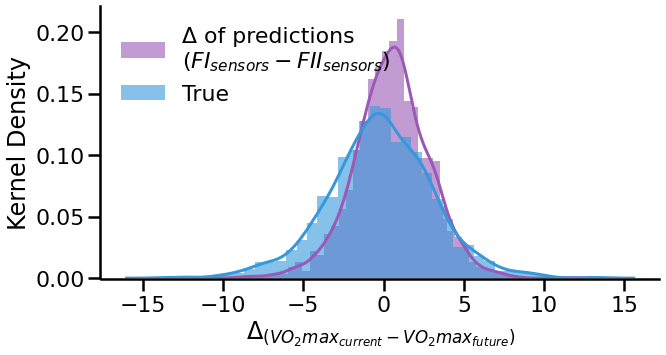

In [431]:
plt.figure(figsize=(10,5))
plt.ylabel('Kernel Density')
sns.despine(offset=1, trim=False)
sns.distplot(adaptability.predicted_delta,color=flatui[0],hist_kws=dict(alpha=0.6), label="Δ of predictions \n$(FI_{sensors}-FII_{sensors})$")
sns.distplot(adaptability.truth_delta,color=flatui[1],hist_kws=dict(alpha=0.6),label="True")
plt.xlabel('$\Delta_{(VO_{2}max_{current}-VO_{2}max_{future})}$')
plt.legend(frameon=False)
ax.grid(False);sns.despine()
#plt.savefig('data/adaptability_distros.pdf', bbox_inches="tight") 

In [432]:
import scipy
scipy.stats.pearsonr(adaptability.predicted_delta.astype(float), adaptability.truth_delta.astype(float))

(0.5706806856850728, 8.628520600424027e-177)

In [433]:
scipy.stats.pearsonr(adaptability.truth_fI.astype(float), adaptability.predicted_fI.astype(float))[0]

0.8230939914029892

In [434]:
adaptability.min(), adaptability.max(),

(predicted_fI       28.2982
 truth_fI             24.01
 id                 500032K
 predicted_fII      26.7036
 truth_fII          24.1009
 predicted_delta   -10.9232
 truth_delta       -13.8646
 dtype: object,
 predicted_fI        50.854
 truth_fI           54.2929
 id                 710472D
 predicted_fII      51.3578
 truth_fII          56.7238
 predicted_delta    11.6532
 truth_delta        13.4356
 dtype: object)

In [435]:
mse, rmse, mae, std_mae, r2, mape, corr =  error_metrics(adaptability.truth_fI.astype(float), adaptability.predicted_fI.astype(float))
print ("MSE:", round(mse,3), 
       "\nRMSE", round(rmse,3),
       "\nMAE", round(mae,3), 
       "\nRˆ2", round(r2,3),
       "\nCorrelation", round(np.corrcoef(adaptability.truth_fI.astype(float), adaptability.predicted_fI.astype(float))[0][1],3)
      )

MSE: 8.541 
RMSE 2.923 
MAE 2.281 
Rˆ2 0.673 
Correlation 0.823


In [436]:
mse, rmse, mae, std_mae, r2, mape, corr =  error_metrics(adaptability.truth_fII.astype(float), adaptability.predicted_fII.astype(float))
print ("MSE:", round(mse,3), 
       "\nRMSE", round(rmse,3),
       "\nMAE", round(mae,3), 
       "\nRˆ2", round(r2,3),
       "\nCorrelation", round(np.corrcoef(adaptability.truth_fII.astype(float), adaptability.predicted_fII.astype(float))[0][1],3)
      )

MSE: 8.575 
RMSE 2.928 
MAE 2.364 
Rˆ2 0.683 
Correlation 0.847


/home/ds806/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


(array([  3.,   1.,   6.,  14.,  35.,  41.,  90., 181., 268., 374., 348.,
        299., 191.,  91.,  56.,  22.,  15.,   5.,   0.,   2.]),
 array([-13.8645669 , -12.49955607, -11.13454525,  -9.76953442,
         -8.4045236 ,  -7.03951277,  -5.67450194,  -4.30949112,
         -2.94448029,  -1.57946946,  -0.21445864,   1.15055219,
          2.51556302,   3.88057384,   5.24558467,   6.6105955 ,
          7.97560632,   9.34061715,  10.70562797,  12.0706388 ,
         13.43564963]),
 <BarContainer object of 20 artists>)

<Figure size 360x360 with 0 Axes>

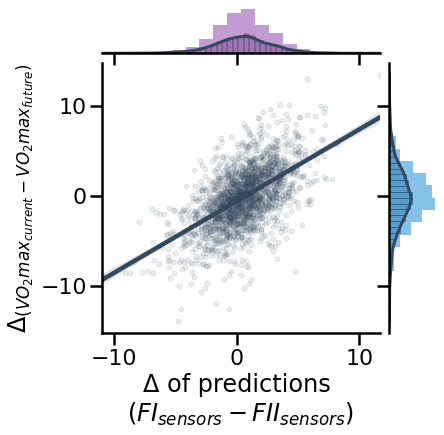

In [437]:
plt.figure(figsize=(5,5))
j = sns.jointplot(x="predicted_delta",
              y="truth_delta",
              data = adaptability,
              scatter_kws={'alpha':0.1, 's': 25},
              lowess=False,
              kind="reg", color=flatui[4])
#j.annotate(scipy.stats.pearsonr[0])
j.ax_joint.set_xlabel("Δ of predictions \n$(FI_{sensors}-FII_{sensors})$") 
j.ax_joint.set_ylabel('$\Delta_{(VO_{2}max_{current}-VO_{2}max_{future})}$') 
j.ax_marg_x.hist(adaptability.predicted_delta,color=flatui[0], alpha=.6, bins=20) #trick to color each histogram
j.ax_marg_y.hist(adaptability.truth_delta, color=flatui[1], alpha=.6,bins=20, orientation="horizontal")
#plt.ylim(-15,15); plt.xlim(-15,15)
#plt.savefig('data/adaptability_correlation.pdf', bbox_inches="tight")


In [587]:
y_test.shape

(2675,)

In [589]:
y_test.mean()

39.97431657495323

In [592]:
y_test.min(), y_test.max()

(24.010044, 56.41304399999999)

<AxesSubplot:>

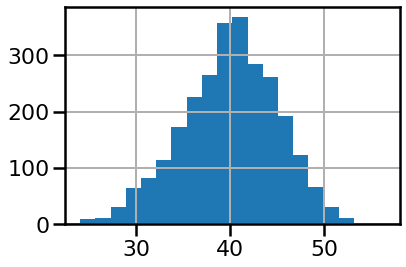

In [591]:
y_test.hist(bins=20)

### Evaluate initial model predictions (distribution and correlation)

/home/ds806/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ds806/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


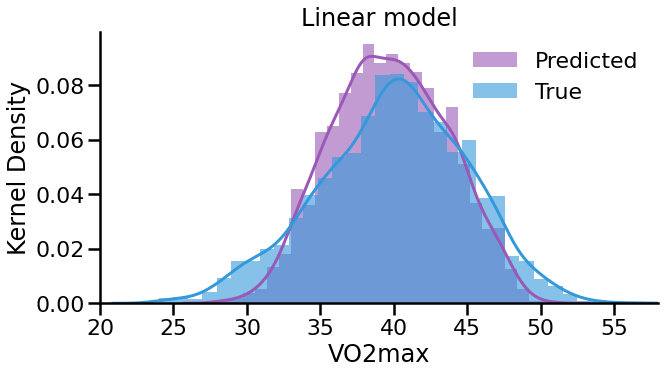

In [109]:
plt.figure(figsize=(10,5))
plt.title("Linear model")
sns.distplot(predicted_vs_truth.predicted,label="Predicted",color=flatui[0],  hist_kws=dict(alpha=0.6))
sns.distplot(predicted_vs_truth.truth,label="True", color=flatui[1], hist_kws=dict(alpha=0.6))
plt.xlabel('VO2max'); plt.ylabel('Kernel Density'); plt.xlim(20,58)
sns.despine()
plt.legend(frameon=False)
#ax.grid(False)
#plt.savefig('data/FI_predicted_true_distro_LINEAR.pdf', bbox_inches="tight") 

/home/ds806/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


<Figure size 360x360 with 0 Axes>

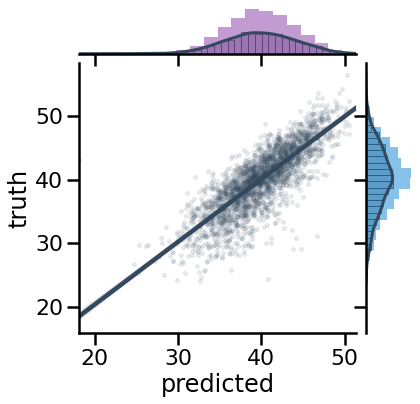

In [516]:
predicted_vs_truth["predicted"] = predicted_vs_truth["predicted"].astype(float)
predicted_vs_truth["truth"] = predicted_vs_truth["truth"].astype(float)

plt.figure(figsize=(5,5))
j = sns.jointplot(x="predicted",
              y="truth",
              data = predicted_vs_truth,
              scatter_kws={'alpha':0.1, 's': 15},
              lowess=False,
              kind="reg", color=flatui[4])
j.ax_marg_x.hist(predicted_vs_truth.predicted,color=flatui[0], alpha=.6, bins=20) #trick to color each histogram
j.ax_marg_y.hist(predicted_vs_truth.truth, color=flatui[1], alpha=.6,bins=20, orientation="horizontal")
plt.xlabel('Predicted'); plt.ylabel('True'); #plt.ylim(20,60); plt.xlim(20,60)
#plt.savefig('data/FI_predicted_true_corr_LINEAR.pdf', bbox_inches="tight") 

In [604]:
y_test.mean()

39.97431657495323

In [605]:
y_test.min(), y_test.max()

(24.010044, 56.41304399999999)

array([[<AxesSubplot:title={'center':'TR_FITNESS_HighPt_est'}>]],
      dtype=object)

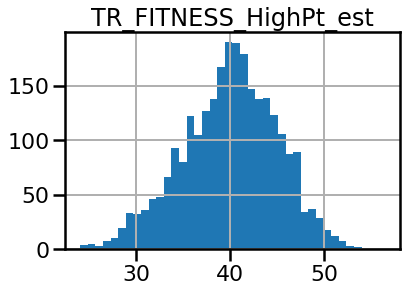

In [606]:
pd.DataFrame(y_test).hist(bins=40)